# Workbook

In [111]:
# import necessary packages

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from IPython import display
import tensorflow as tf
import pandas as pd
import librosa

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [112]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.listdir('/content/drive/My Drive/')

# audio_path = '/content/drive/My Drive/dataset/AUDIO_NEW/'

audio_path = 'dataset/AUDIO_NEW/'

audio_types = ['breathing', 'cough', 'speech']

In [113]:
def get_directories(audio_path, audio_type):
    from pathlib import Path

    POS = os.path.join(audio_path + audio_type, 'COVID_Positive')
    NEG = os.path.join(audio_path + audio_type, 'COVID_Negative')

    # Specify the directory path
    pos_directory = Path(POS)
    neg_directory = Path(NEG)

    # List all files in the directory using iterdir()
    # pos_files = [file.name for file in pos_directory.iterdir() if file.is_file()]
    # neg_files = [file.name for file in neg_directory.iterdir() if file.is_file()]

    return pos_directory, neg_directory

### Creating features

In [114]:
# Load and process breathing data
pos_directory_breathing, neg_directory_breathing = get_directories(audio_path, audio_types[0])

# Load and process cough data
pos_directory_cough, neg_directory_cough = get_directories(audio_path, audio_types[1]) # audio_types[1] is 'cough'

# Load and process speech data
pos_directory_speech, neg_directory_speech = get_directories(audio_path, audio_types[2]) # audio_types[2] is 'speech'


In [115]:
# might want to consider denoising the audio files before processing them

In [116]:
def create_mel_spectrogram(y, sr, file_path):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=128)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Normalize the spectrogram
    if np.std(log_mel_spectrogram) == 0:
        print("log_mel_spectrogram == 0: ", file_path.resolve())
    
    # Normalize the spectrogram
    epsilon = 1e-6  # Small value to avoid division by zero
    log_mel_spectrogram = (log_mel_spectrogram - np.mean(log_mel_spectrogram)) / (np.std(log_mel_spectrogram) + epsilon)

    # Add channel dimension
    log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)

    return log_mel_spectrogram

def create_zero_crossing_rate(y):
    return np.mean(librosa.feature.zero_crossing_rate(y))

def create_spectral_centroid(y, sr):
    return np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

In [117]:
def create_features(pos_directory, neg_directory, target_length):
    print("Creating features for {0} and {1}! ".format(pos_directory, neg_directory))
    spectrograms = []
    other_features = []
    labels = []

    # Access files directly using iterdir()
    for file_path in sorted(pos_directory.iterdir()):
        y, sr = librosa.load(file_path, sr=16000)
        y = y[:target_length]

        zero_padding = np.zeros(target_length - len(y), dtype=np.float32)
        y = np.concatenate([y, zero_padding], axis=0)

        spectrograms.append(create_mel_spectrogram(y, sr, file_path))
        other_features.append([create_zero_crossing_rate(y), create_spectral_centroid(y, sr)])
        labels.append(1)
    
    positive_samples = len(labels)
    assert positive_samples == 172

    for file_path in sorted(neg_directory.iterdir()):
        y, sr = librosa.load(file_path, sr=16000)
        y = y[:target_length]

        zero_padding = np.zeros(target_length - len(y), dtype=np.float32)
        y = np.concatenate([y, zero_padding], axis=0)

        spectrograms.append(create_mel_spectrogram(y, sr, file_path))
        other_features.append([create_zero_crossing_rate(y), create_spectral_centroid(y, sr)])
        labels.append(0)

    assert len(labels) - positive_samples == 793

    print("Completed creating features for {0} and {1}! ".format(pos_directory, neg_directory))

    return spectrograms, other_features, labels

In [156]:
# creating spectrogram, other features, and labels for breathing, cough, and speech

spectrograms_breathing, other_features_breathing, labels_breathing = create_features(pos_directory_breathing, neg_directory_breathing, 80000)

Creating features for dataset/AUDIO_NEW/breathing/COVID_Positive and dataset/AUDIO_NEW/breathing/COVID_Negative! 
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/GDOLSUHV.flac
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/HTUZHMVC.flac
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/TMWZXJNT.flac
Completed creating features for dataset/AUDIO_NEW/breathing/COVID_Positive and dataset/AUDIO_NEW/breathing/COVID_Negative! 


In [157]:
spectrograms_cough, other_features_cough, labels_cough = create_features(pos_directory_cough, neg_directory_cough, 96000) # 6 seconds 

# 25th Percentile Duration: 4.693333333333333
# Median Duration: 6.058684807256236
# 75th Percentile Duration: 7.509319727891157

Creating features for dataset/AUDIO_NEW/cough/COVID_Positive and dataset/AUDIO_NEW/cough/COVID_Negative! 
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/cough/COVID_Negative/TMWZXJNT.flac
Completed creating features for dataset/AUDIO_NEW/cough/COVID_Positive and dataset/AUDIO_NEW/cough/COVID_Negative! 


In [158]:
spectrograms_speech, other_features_speech, labels_speech = create_features(pos_directory_speech, neg_directory_speech, 160000) # 10 seconds

# 25th Percentile Duration: 12.458684807256235
# Median Duration: 14.421337868480725
# 75th Percentile Duration: 16.55467120181406

Creating features for dataset/AUDIO_NEW/speech/COVID_Positive and dataset/AUDIO_NEW/speech/COVID_Negative! 
Completed creating features for dataset/AUDIO_NEW/speech/COVID_Positive and dataset/AUDIO_NEW/speech/COVID_Negative! 


In [172]:
# Define a function to pad spectrograms to the maximum time frame length
def pad_spectrogram(spectrogram, max_time_frames):
    current_time_frames = spectrogram.shape[1]  # Time frames are along axis 1
    if current_time_frames < max_time_frames:
        # Calculate padding amount
        padding_amount = max_time_frames - current_time_frames
        # Pad along the time axis (axis=1)
        padded_spectrogram = np.pad(spectrogram, ((0, 0), (0, padding_amount), (0, 0)), mode='constant')
    else:
        padded_spectrogram = spectrogram
    return padded_spectrogram

# Maximum time frame length across all audio types
max_time_frames = 1251

# Pad all spectrograms to the maximum time frame length
padded_spectrograms_breathing = [pad_spectrogram(s, max_time_frames) for s in spectrograms_breathing]
padded_spectrograms_cough = [pad_spectrogram(s, max_time_frames) for s in spectrograms_cough]
padded_spectrograms_speech = [pad_spectrogram(s, max_time_frames) for s in spectrograms_speech]

In [168]:
padded_spectrograms_breathing[0].shape, padded_spectrograms_cough[0].shape, padded_spectrograms_speech[0].shape

((128, 1251, 1), (128, 1251, 1), (128, 1251, 1))

In [169]:
# Combine spectrograms, other features, and labels for each participant
all_spectrograms = []
all_other_features = []
all_labels = []

# Assuming all lists are sorted in the same order and correspond to the same participants
for i in range(len(spectrograms_breathing)):  # Iterate over participants
    # Combine spectrograms for breathing, coughing, and speech along the time axis
    # combined_spectrogram = np.concatenate(
    #     [spectrograms_breathing[i], spectrograms_cough[i], spectrograms_speech[i]], axis=-1
    # )
    combined_spectrogram = np.concatenate(
        [padded_spectrograms_breathing[i], padded_spectrograms_cough[i], padded_spectrograms_speech[i]], axis=1
    )
    
    # Combine other features for breathing, coughing, and speech
    combined_other_features = np.concatenate(
        [other_features_breathing[i], other_features_cough[i], other_features_speech[i]], axis=0
    )
    
    # Assume labels are consistent across all audio types for a participant
    label = labels_breathing[i]  # You can use any of the label lists since they are consistent

    # Append combined data to the final lists
    all_spectrograms.append(combined_spectrogram)
    all_other_features.append(combined_other_features)
    all_labels.append(label)

# Convert to NumPy arrays
all_spectrograms = np.array(all_spectrograms)
all_other_features = np.array(all_other_features)
all_labels = np.array(all_labels)

# Flatten spectrograms and combine with other features
all_spectrograms_flattened = all_spectrograms.reshape(all_spectrograms.shape[0], -1)
X_combined = np.hstack([all_spectrograms_flattened, all_other_features])


In [123]:
# Shazia's Code
# all_spectrograms = spectrograms_cough + spectrograms_speech + spectrograms_breathing
# all_other_features = other_features_cough + other_features_speech + other_features_breathing
# all_labels = labels_cough + labels_speech + labels_breathing

# # Convert to NumPy arrays
# all_spectrograms = np.array(all_spectrograms)
# all_other_features = np.array(all_other_features)
# all_labels = np.array(all_labels)
# all_spectrograms_flattened = all_spectrograms.reshape(all_spectrograms.shape[0], -1)

In [ ]:
# X_combined = np.hstack([all_spectrograms_flattened, all_other_features])

In [175]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_combined, all_labels, test_size=0.2, stratify=all_labels)

In [14]:
# Flatten each spectrogram into a single vector
# Resulting shape will be (num_samples, height * width * channels)
# X_train_numpy = np.array(X_train)
# X_train_flattened = X_train_numpy.reshape(X_train_numpy.shape[0], -1)

# print(f"Original shape: {X_train_numpy.shape}")
# print(f"Flattened shape: {X_train_flattened.shape}")

We used the `SMOTEENN` function in the imblearn library to handle imbalanced datasets by oversampling `1`, the minority class and remove noisy samples. 

In [176]:
#!pip install imbalanced-learn
from imblearn.combine import SMOTEENN
from collections import Counter

smote_enn = SMOTEENN(random_state=seed)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

In [177]:
# Print resampled class distribution
print(f"Original class distribution: {Counter(y_train)}")
print(f"Resampled class distribution: {Counter(y_train_resampled)}")

Original class distribution: Counter({np.int64(0): 634, np.int64(1): 138})
Resampled class distribution: Counter({np.int64(1): 625, np.int64(0): 91})


In [17]:
# # Reshape back to original format after resampling
# X_resampled = X_resampled.reshape(X_resampled.shape[0], 128, 626, 1)

# print(f"Reshaped back to original format: {X_resampled.shape}")

In [178]:
# num_time_frames will change depending on the audio_type 

# num_mel_bands = 128
# num_time_frames = 626  # Original time frames per spectrogram
# num_spectrogram_features = num_mel_bands * num_time_frames * 3

# Constants for updated time frames
num_mel_bands = 128
original_time_frames_breathing = 626 # prev: 622
original_time_frames_coughing = 751 # prev: 747
original_time_frames_speech = 1251 # prev: 1247

# Total original time frames
original_total_time_frames = original_time_frames_breathing + original_time_frames_coughing + original_time_frames_speech

# Total spectrogram features
total_padded_spectrogram_features = num_mel_bands * (max_time_frames * 3)

In [179]:
# Separate resampled padded spectrograms and other features for X_train_resampled
padded_spectrograms_resampled = X_train_resampled[:, :total_padded_spectrogram_features]
other_features_resampled = X_train_resampled[:, total_padded_spectrogram_features:]

In [180]:
padded_spectrograms_resampled.shape, other_features_resampled.shape

((716, 480384), (716, 6))

In [182]:
# Verify actual size
print("Actual size of padded_spectrograms_resampled:", padded_spectrograms_resampled.size)

# Calculate expected size
expected_size = 716 * 128 * (max_time_frames * 3) * 1
print("Expected size for reshaping:", expected_size)

Actual size of padded_spectrograms_resampled: 343954944
Expected size for reshaping: 343954944


In [183]:
# Reshape the flattened spectrograms back to their original shape (128x626)
# spectrograms_resampled_reshaped = spectrograms_resampled.reshape(
#     spectrograms_resampled.shape[0], num_mel_bands, num_time_frames * 3, 1
# )

padded_spectrograms_resampled_reshaped = padded_spectrograms_resampled.reshape(
    padded_spectrograms_resampled.shape[0], num_mel_bands,
    max_time_frames * 3, 1
)


In [184]:
padded_spectrograms_resampled_reshaped.shape

(716, 128, 3753, 1)

In [188]:
# Define a function to extract the original spectrograms without padding
def extract_original_spectrograms(padded_spectrograms, time_frames_breathing, time_frames_coughing, time_frames_speech):
    # Extract breathing spectrogram
    breathing = padded_spectrograms[:, :, :time_frames_breathing, :]
    
    # Extract coughing spectrogram
    coughing_start = time_frames_breathing
    coughing_end = time_frames_breathing + time_frames_coughing
    coughing = padded_spectrograms[:, :, coughing_start:coughing_end, :]
    
    # Extract speech spectrogram
    speech_start = coughing_end
    speech_end = speech_start + time_frames_speech
    speech = padded_spectrograms[:, :, speech_start:speech_end, :]
    
    return breathing, coughing, speech

# Extract the original spectrograms from the padded data
spectrograms_train_breathing, spectrograms_train_coughing, spectrograms_train_speech = extract_original_spectrograms(
    padded_spectrograms_resampled_reshaped,
    original_time_frames_breathing,
    original_time_frames_coughing,
    original_time_frames_speech
)

In [189]:
# Verify the shapes of the extracted spectrograms
print("Breathing Spectrogram Shape:", spectrograms_train_breathing.shape)  # Expected: (num_samples, 128, 622, 1)
print("Coughing Spectrogram Shape:", spectrograms_train_coughing.shape)   # Expected: (num_samples, 128, 747, 1)
print("Speech Spectrogram Shape:", spectrograms_train_speech.shape)       # Expected: (num_samples, 128, 1247, 1)

Breathing Spectrogram Shape: (716, 128, 626, 1)
Coughing Spectrogram Shape: (716, 128, 751, 1)
Speech Spectrogram Shape: (716, 128, 1251, 1)


In [ ]:
# Separate into breathing, coughing, and speech
# spectrograms_train_breathing_resampled = spectrograms_resampled_reshaped[:, :, :num_time_frames, :]
# spectrograms_train_coughing_resampled = spectrograms_resampled_reshaped[:, :, num_time_frames:num_time_frames*2, :]
# spectrograms_train_speech_resampled = spectrograms_resampled_reshaped[:, :, num_time_frames*2:, :]

Breathing Spectrogram Shape: (724, 128, 626, 1)
Coughing Spectrogram Shape: (724, 128, 626, 1)
Speech Spectrogram Shape: (724, 128, 626, 1)


In [22]:
# Optionally add a channel dimension for CNN input (e.g., shape: [samples, 128, 626, 1])
#spectrograms_resampled_reshaped = np.expand_dims(spectrograms_resampled_reshaped, axis=-1)

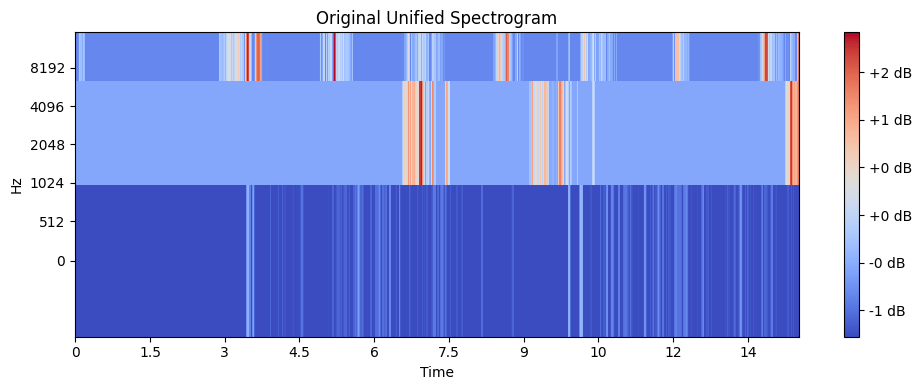

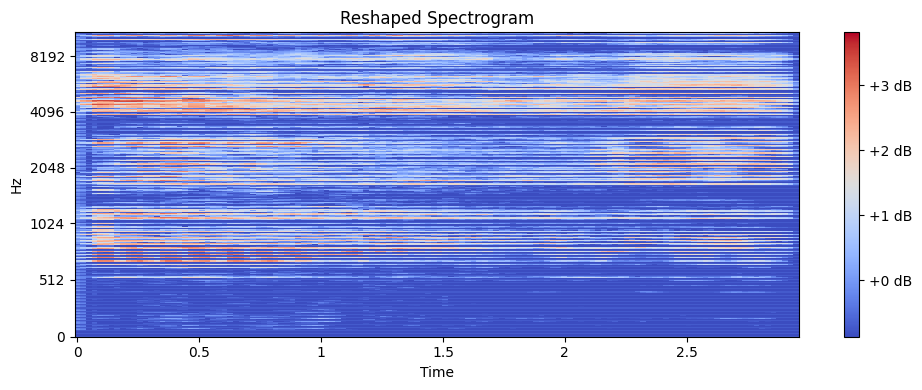

In [ ]:
# import random
# import matplotlib.pyplot as plt
# import librosa.display

# # Function to plot spectrogram
# def plot_spectrogram(spectrogram, title):
#     plt.figure(figsize=(10, 4))
#     # Remove channel dimension if present for visualization
#     if spectrogram.shape[-1] == 1:
#         spectrogram = spectrogram.squeeze(-1)
#     librosa.display.specshow(spectrogram.T, sr=22050, x_axis='time', y_axis='mel')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title(title)
#     plt.tight_layout()
#     plt.show()

# # Assuming 'original_spectrogram' is your original unflattened spectrogram
# # and 'reshaped_spectrogram' is your reshaped version after processing

# # Plot original spectrogram (before flattening)
# plot_spectrogram(all_spectrograms[0][0], "Original Unified Spectrogram")

# plot_spectrogram(spectrograms_breathing[100], "Reshaped Spectrogram")



### Process X_test

In [190]:
# For X_test (no resampling needed), separate and reshape the spectrograms
spectrograms_test = X_test[:, :total_padded_spectrogram_features]
other_features_test = X_test[:, total_padded_spectrogram_features:]

In [192]:
spectrograms_test.shape, other_features_test.shape

((193, 480384), (193, 6))

In [193]:
spectrograms_test_reshaped = spectrograms_test.reshape(
    spectrograms_test.shape[0], num_mel_bands, max_time_frames * 3, 1
)

In [226]:
# Separate spectrogram_test_reshaped into breathing, coughing, and speech
# spectrograms_test_breathing_resampled = spectrograms_test_reshaped[:, :, :num_time_frames, :]
# spectrograms_test_coughing_resampled = spectrograms_test_reshaped[:, :, num_time_frames:num_time_frames*2, :]
# spectrograms_test_speech_resampled = spectrograms_test_reshaped[:, :, num_time_frames*2:, :]

spectrograms_test_breathing, spectrograms_test_coughing, spectrograms_test_speech = extract_original_spectrograms(
    spectrograms_test_reshaped,
    original_time_frames_breathing,
    original_time_frames_coughing,
    original_time_frames_speech
)
# Verify shapes
print("Breathing Spectrogram Shape:", spectrograms_test_breathing.shape)
print("Coughing Spectrogram Shape:", spectrograms_test_coughing.shape)
print("Speech Spectrogram Shape:", spectrograms_test_speech.shape)


Breathing Spectrogram Shape: (193, 128, 626, 1)
Coughing Spectrogram Shape: (193, 128, 751, 1)
Speech Spectrogram Shape: (193, 128, 1251, 1)


In [196]:
#convert y_train_resampled and y_test to numpy arrays

y_train_resampled = np.array(y_train_resampled)
y_test = np.array(y_test)

### Single input model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D

In [30]:
model = Sequential()
model.add(Input(shape=(128,626,1)))

# First Conv2D layer followed by MaxPooling
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Reduces spatial dimensions by half

# Second Conv2D layer followed by MaxPooling
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Further reduces spatial dimensions

# Third Conv2D layer followed by MaxPooling
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Further reduces spatial dimensions

# Fourth Conv2D layer followed by MaxPooling (new)
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # Further reduces spatial dimensions

# Flatten and Dense layers
#model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 624, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 312, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 310, 16)    │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 155, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 153, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 76, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 37, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,065 (133.07 KB)

 Trainable params: 34,065 (133.07 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Reshape X_train_spectrograms to have the same shape as the spectrograms_resampled_reshaped
# using num_spectrogram_features, which is 128 * 626 in this case.
# X_train_spectrograms = X_train[:, :num_spectrogram_features]  # Extract spectrogram features from training data
# X_train_spectrograms_reshaped = X_train_spectrograms.reshape(X_train_spectrograms.shape[0], 128, 626, 1)  # Reshape to (samples, 128, 626, 1)


# hist = model.fit(
#     X_train_spectrograms_reshaped,  # Pass the reshaped TRAINING spectrograms as input
#     y_train,  # Labels
#     batch_size=16,
#     verbose=2,
#     epochs=20,
#     validation_split=0.1
# )
hist = model.fit(
    X_train_resampled[:, :num_spectrogram_features].reshape(-1, 128, 626, 1),  # Mel spectrograms
    y_train_resampled,
    batch_size=8,
    verbose=2,
    epochs=10,
    validation_split=0.1
)

Epoch 1/10
250/250 - 70s - loss: 0.4784 - recall: 1.0000 - precision: 0.8208 - val_loss: 0.2032 - val_recall: 1.0000 - val_precision: 1.0000 - 70s/epoch - 281ms/step
Epoch 2/10
250/250 - 65s - loss: 0.4452 - recall: 1.0000 - precision: 0.8208 - val_loss: 0.1918 - val_recall: 1.0000 - val_precision: 1.0000 - 65s/epoch - 262ms/step
Epoch 3/10
250/250 - 66s - loss: 0.4105 - recall: 0.9817 - precision: 0.8312 - val_loss: 0.2876 - val_recall: 0.9507 - val_precision: 1.0000 - 66s/epoch - 266ms/step
Epoch 4/10
250/250 - 66s - loss: 0.3659 - recall: 0.9713 - precision: 0.8546 - val_loss: 0.2779 - val_recall: 0.9193 - val_precision: 1.0000 - 66s/epoch - 262ms/step
Epoch 5/10
250/250 - 65s - loss: 0.3466 - recall: 0.9524 - precision: 0.8707 - val_loss: 0.0726 - val_recall: 0.9910 - val_precision: 1.0000 - 65s/epoch - 260ms/step
Epoch 6/10
250/250 - 66s - loss: 0.3283 - recall: 0.9451 - precision: 0.8827 - val_loss: 0.0659 - val_recall: 0.9955 - val_precision: 1.0000 - 66s/epoch - 262ms/step
Epoc

### Fit Model, View Loss and KPI Plots

In [37]:
# Assuming 'num_spectrogram_features' is defined earlier

# Extract and reshape spectrograms
X_test_spectrograms = X_test[:, :num_spectrogram_features]
X_test_spectrograms_reshaped = X_test_spectrograms.reshape(X_test_spectrograms.shape[0], 128, 626, 1)

# Extract other features
X_test_other_features = X_test[:, num_spectrogram_features:]

# Make predictions
y_pred = model.predict(X_test_spectrograms_reshaped)


19/19 [==============================] - 6s 322ms/step


In [38]:
y_pred_binary = (y_pred > 0.99).astype(int)

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_binary)

In [40]:
len(y_test)

579

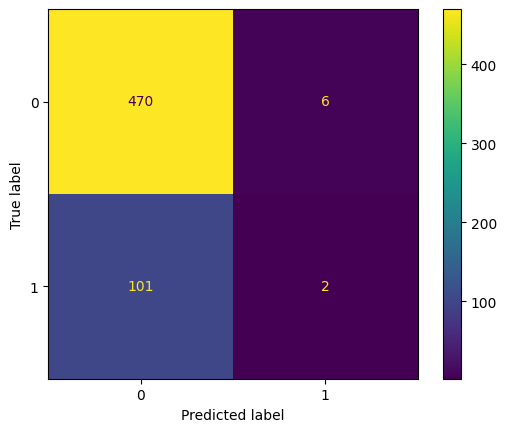

In [41]:
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

### Multi-input model

In [201]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Concatenate, Dropout

# Define input for Mel spectrogram (shape: 625 time frames x 128 frequency bins x 1 channel)
mel_input_breathing = Input(shape=(128, 626, 1), name='mel_spectrogram_breathing')
mel_input_cough = Input(shape=(128, 751, 1), name='mel_spectrogram_cough')
mel_input_speech = Input(shape=(128, 1251, 1), name='mel_spectrogram_speech')


# Define CNN sub-network for Mel spectrogram
def create_cnn_subnetwork(input_layer):
    x = Conv2D(16, (3,3), activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(16, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(32, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = GlobalAveragePooling2D()(x)

    return x

# Create CNN sub-networks for each spectrogram input
cnn_breathing_output = create_cnn_subnetwork(mel_input_breathing)
cnn_cough_output = create_cnn_subnetwork(mel_input_cough)
cnn_speech_output = create_cnn_subnetwork(mel_input_speech)

# Define input for other features (zero-crossing rate and spectral centroid)
other_input = Input(shape=(6,), name='other_features')

# Define a simple dense sub-network for other features
y = Dense(64, activation='relu')(other_input)
y = Dense(128, activation='relu')(y)  # Add more dense layers
y = Dropout(0.3)(y)                   # Add dropout to prevent overfitting
y = Dense(128, activation='relu')(y)   # Another dense layer
y = Dense(64, activation='relu')(y)    # Another dense layer

# Concatenate both sub-networks
combined = Concatenate()([cnn_breathing_output, cnn_cough_output, cnn_speech_output, y])

# Add final classification layers
z = Dense(128, activation='relu')(combined)
z = Dropout(0.3)(z)                    # Add dropout to prevent overfitting
z = Dense(64, activation='relu')(z)
z = Dense(1, activation='sigmoid')(z)  # Binary classification

In [202]:
# Define the model with two inputs
model = tf.keras.Model(inputs=[mel_input_breathing, mel_input_cough, mel_input_speech, other_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','recall','precision'])

# Print model summary
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mel_spectrogram_br… │ (None, 128, 626,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mel_spectrogram_co… │ (None, 128, 751,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mel_spectrogram_sp… │ (None, 128, 1251, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 126, 624,  │        160 │ mel_spectrogram_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 126, 749,  │        160 │ mel_spectrogram_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 126, 1249, │        160 │ mel_spectrogram_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 63, 312,   │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 63, 374,   │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 63, 624,   │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 61, 310,   │      2,320 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 61, 372,   │      2,320 │ max_pooling2d_8[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 61, 622,   │      2,320 │ max_pooling2d_12… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 30, 155,   │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 30, 186,   │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 30, 311,   │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_features      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 153,   │      4,640 │ max_pooling2d_5[

 Total params: 151,601 (592.19 KB)

 Trainable params: 151,601 (592.19 KB)

 Non-trainable params: 0 (0.00 B)

In [198]:
y_train_resampled.shape

(716,)

In [199]:
X_train_breathing, X_val_breathing, \
X_train_coughing, X_val_coughing, \
X_train_speech, X_val_speech, \
X_train_other_features, X_val_other_features, \
y_train, y_val = train_test_split(
    spectrograms_train_breathing,
    spectrograms_train_coughing,
    spectrograms_train_speech,
    other_features_resampled,
    y_train_resampled,
    test_size=0.2,
    random_state=seed,
    stratify=y_train_resampled
)

# Step 2: Verify shapes of training and validation sets
print("Training set shapes:")
print("Breathing:", X_train_breathing.shape)
print("Coughing:", X_train_coughing.shape)
print("Speech:", X_train_speech.shape)
print("Other Features:", X_train_other_features.shape)
print("Labels:", y_train.shape)

print("\nValidation set shapes:")
print("Breathing:", X_val_breathing.shape)
print("Coughing:", X_val_coughing.shape)
print("Speech:", X_val_speech.shape)
print("Other Features:", X_val_other_features.shape)
print("Labels:", y_val.shape)


Training set shapes:
Breathing: (572, 128, 626, 1)
Coughing: (572, 128, 751, 1)
Speech: (572, 128, 1251, 1)
Other Features: (572, 6)
Labels: (572,)

Validation set shapes:
Breathing: (144, 128, 626, 1)
Coughing: (144, 128, 751, 1)
Speech: (144, 128, 1251, 1)
Other Features: (144, 6)
Labels: (144,)


In [204]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor (e.g., validation loss)
    patience=5,                 # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the weights of the best epoch
    verbose=1                   # Print messages when early stopping is triggered
)

history = model.fit(
    [X_train_breathing, X_train_coughing, X_train_speech, X_train_other_features],
    y_train,
    validation_data=(
        [X_val_breathing, X_val_coughing, X_val_speech, X_val_other_features],
        y_val
    ),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)


# Step 4: Evaluate the model on the validation set
results = model.evaluate(
    [X_val_breathing, X_val_coughing, X_val_speech, X_val_other_features],
    y_val
)

# Print all evaluation metrics
for metric_name, metric_value in zip(model.metrics_names, results):
    print(f"{metric_name}: {metric_value}")

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7876 - loss: 2.3042 - precision: 0.8879 - recall: 0.8703 - val_accuracy: 0.8681 - val_loss: 1.0385 - val_precision: 0.8741 - val_recall: 0.9921
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8284 - loss: 1.8146 - precision: 0.8914 - recall: 0.9191 - val_accuracy: 0.7639 - val_loss: 0.6254 - val_precision: 0.8594 - val_recall: 0.8730
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.7695 - loss: 1.5040 - precision: 0.8935 - recall: 0.8424 - val_accuracy: 0.9028 - val_loss: 0.3791 - val_precision: 0.9000 - val_recall: 1.0000
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8077 - loss: 0.8177 - precision: 0.8956 - recall: 0.8876 - val_accuracy: 0.8750 - val_loss: 0.6339 - val_precision: 0.8750 - val_recall: 1.0000
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7939 - loss: 1.1560 - precision: 0.8975 - recall: 0.8702 - val_accuracy: 0.8542 - val_loss: 0.4142 - val

In [ ]:
# recall = TP / TP + FN 

In [205]:
y_pred_train = model.predict([X_train_breathing, X_train_coughing, X_train_speech, X_train_other_features])

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step


In [220]:
y_pred_train_binary = (y_pred_train > 0.6).astype(int)

In [221]:
y_train.shape, y_pred_train_binary.shape

((572,), (572, 1))

In [222]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train_binary)

print(f"Training Accuracy: {accuracy_train}")

Training Accuracy: 0.8671328671328671


In [223]:
accuracy_train

0.8671328671328671

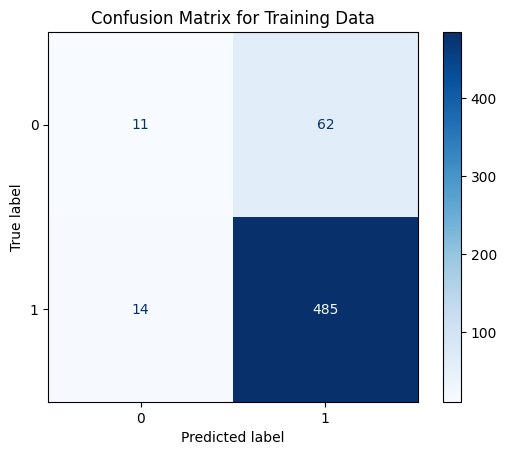

In [224]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_train, y_pred_train_binary)

# Step 4: Visualize or print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Training Data")
plt.show()

In [227]:
y_pred_test = model.predict([spectrograms_test_breathing, spectrograms_test_coughing, spectrograms_test_speech, other_features_test])

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step


In [229]:
y_pred_test_binary = (y_pred_test > 0.6).astype(int)

In [230]:
cm = confusion_matrix(y_test, y_pred_test_binary)

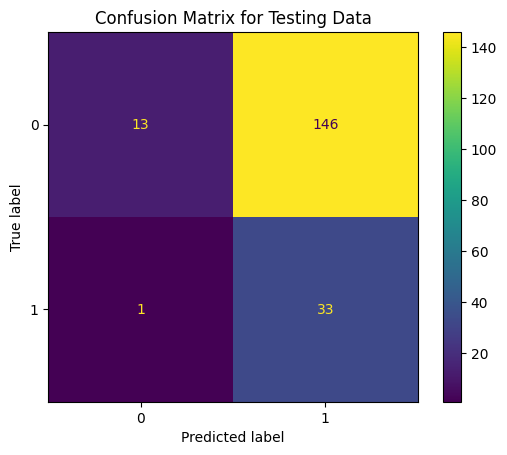

In [231]:
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.title("Confusion Matrix for Testing Data")
plt.show()

In [233]:
accuracy_test = accuracy_score(y_test, y_pred_test_binary)
accuracy_test

0.23834196891191708